# 3 Machine Learning - Enhanced Data

A score of 1.5 on Neuroticism means different things for a 40 year old male and a 16 year old female. I think that could be the reason for lower Pearson product-moment correlation values for Big Five traits.

The International Personality Item Pool (IPIP) is a public domain collection of items for use in personality tests managed by the Oregon Research Institute. On their site we can read:

"To interpret individuals' [personality] scores, one might calculate the mean and standard deviation (SD) for a sample of persons, usually of the same sex and a particular age range, and interpret scores within one-half SD of the mean as "average."

That was the reason why I suspected the results of personality predictions were so low - they were based only on Facebook Likes and not Users' age or gender. And while liking a young celebrity or influencer may give some indication of Users' age and gender, if we have this data explicitly stated as a reference for personality scores, I believe we can get much better predictions.

In [1]:
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils import load_user_like_matrix, plot_roc_curve

In [2]:
users = pd.read_csv('data/users_trimmed.csv')
users = users.drop(['political', 'userid'], axis='columns')

In [3]:
users = users.drop('Unnamed: 0', axis='columns')

In [4]:
users

,gender,age,ope,con,ext,agr,neu
0,0,47,-0.31,-0.57,-0.89,0.41,1.17
1,0,35,0.61,-0.12,-0.64,-1.01,-1.50
2,1,29,-0.31,-0.94,-0.77,-1.76,1.05
3,1,28,-0.68,0.54,-0.52,-1.01,-0.51
4,0,35,-0.41,-0.86,-1.02,-0.18,0.30
...,...,...,...,...,...,...,...
19737,1,23,-0.31,-1.97,-1.21,-1.09,1.79
19738,1,26,1.26,0.17,1.11,0.12,0.18
19739,1,20,-0.04,0.69,0.17,0.82,0.80
19740,1,35,1.63,-0.72,1.86,1.41,-1.01


In [5]:
df = load_user_like_matrix()

## SVD <i>k</i> = 50

As with the baseline I'll start with 50 dimensions for SVD.

Data preparation:

In [6]:
svd_50 = TruncatedSVD(n_components=50, random_state=42)

In [7]:
svd_50.fit(df)

TruncatedSVD(n_components=50, random_state=42)

In [8]:
X_svd_50 = svd_50.transform(df)

In [9]:
X_svd_50 = pd.DataFrame(X_svd_50)

In [10]:
merged_svd_50 = pd.concat([users, X_svd_50], axis=1)

In [11]:
merged_svd_50

,gender,age,ope,con,ext,agr,neu,0,1,2,...,40,41,42,43,44,45,46,47,48,49
0,0,47,-0.31,-0.57,-0.89,0.41,1.17,0.242033,-0.407787,0.461242,...,-0.166992,0.086621,0.452880,-0.251522,0.112301,-0.134991,-0.022330,0.067848,0.028435,-0.188740
1,0,35,0.61,-0.12,-0.64,-1.01,-1.50,0.430053,-0.701633,0.507358,...,-0.166240,-0.126951,0.206703,-0.675187,-0.208379,-0.279976,-0.483428,-0.049299,0.315360,0.122851
2,1,29,-0.31,-0.94,-0.77,-1.76,1.05,0.720854,-1.007212,0.147107,...,0.105962,-0.053665,0.308653,0.094177,0.132226,-0.520239,-0.247787,0.174664,0.228318,0.093811
3,1,28,-0.68,0.54,-0.52,-1.01,-0.51,1.285244,-1.994454,0.753390,...,0.789653,-0.248334,0.613529,0.378949,-0.449087,-0.773445,-0.420456,-0.237375,-0.027646,-0.729595
4,0,35,-0.41,-0.86,-1.02,-0.18,0.30,0.387822,-0.664859,0.816163,...,-0.255670,0.300201,0.129738,0.119602,-0.138349,0.100356,-0.036676,-0.004481,0.133341,0.278207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19737,1,23,-0.31,-1.97,-1.21,-1.09,1.79,2.009041,-1.722350,-1.511812,...,0.231533,-0.412382,0.677956,0.212807,-0.553049,0.214805,-0.349175,-0.360545,0.261651,-0.438740
19738,1,26,1.26,0.17,1.11,0.12,0.18,5.007482,-7.439148,7.282037,...,1.006846,1.236978,-2.173863,2.181111,-0.631921,0.207862,0.497802,-0.142507,0.656912,0.001547
19739,1,20,-0.04,0.69,0.17,0.82,0.80,1.006331,-1.166541,-0.449694,...,0.791618,-0.041324,-0.109731,-0.187362,-0.042231,0.250531,0.312826,-0.116730,0.116504,-0.331054
19740,1,35,1.63,-0.72,1.86,1.41,-1.01,0.933533,-1.535354,1.325101,...,-0.247148,-0.051479,-0.183399,0.234328,0.168296,0.434699,0.331103,-0.202796,0.002396,0.008595


Getting predictions:

In [12]:
merged_svd_50_results = {}
merged_svd_50_results['name'] = 'merged_svd_50_results'

In [13]:
logreg_targets = ['gender']
linreg_targets = ['age', 'ope', 'con', 'ext', 'agr', 'neu']

I want to score linear regression models on Pearson product-moment correlation (like the Authors did):

In [14]:
def pearson_cor(y_true, y_pred, **kwargs):
    return pearsonr(y_true, y_pred)[0]

pearson_scorer = make_scorer(pearson_cor)

In [15]:
for target in linreg_targets:
    y = users[target]
    
    # In each loop X must be created anew:
    loop_merged = pd.concat([users, merged_svd_50], axis=1)
    loop_merged.columns = loop_merged.columns.astype(str)
    loop_merged = loop_merged.drop(target, axis='columns')

    X_train, X_test, y_train, y_test = train_test_split(
        loop_merged, y, test_size=0.1, random_state=42)

    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)

    merged_svd_50_results[target] = round(cross_val_score(
        model, loop_merged, y, scoring=pearson_scorer, cv=10, n_jobs=-1).mean(), 2)

In [16]:
merged_svd_50_results

{'name': 'merged_svd_50_results',
 'age': 0.59,
 'ope': 0.51,
 'con': 0.45,
 'ext': 0.56,
 'agr': 0.5,
 'neu': 0.64}

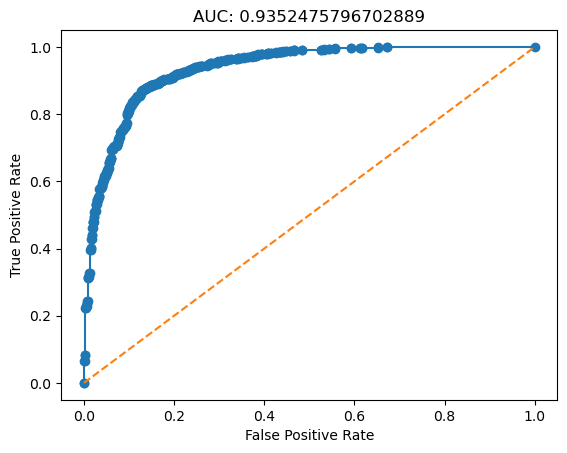

In [17]:
# Even though there's only one target in logreg_targets, I'm leaving this as
# a loop so that I can add e.g. 'political' in here in the future.

for target in logreg_targets:
    y = users[target]
    
    # In each loop X must be created anew:
    loop_merged = pd.concat([users, merged_svd_50], axis=1)
    loop_merged.columns = loop_merged.columns.astype(str)
    loop_merged = loop_merged.drop(target, axis='columns')

    X_train, X_test, y_train, y_test = train_test_split(
        loop_merged, y, test_size=0.1, random_state=42)

    model = LogisticRegression(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    merged_svd_50_results[target] = round(cross_val_score(
        model, loop_merged, y, scoring='roc_auc', cv=10, n_jobs=-1).mean(), 2)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    plot_roc_curve(y_test, y_pred_proba)

In [18]:
merged_svd_50_results

{'name': 'merged_svd_50_results',
 'age': 0.59,
 'ope': 0.51,
 'con': 0.45,
 'ext': 0.56,
 'agr': 0.5,
 'neu': 0.64,
 'gender': 0.94}

We can see significant improvement on Big Five scores after enhancing our reduced User-Like matrix with additional features.

### Impact of additional features

At this point I'm wondering how much of this result is due to using just Big5, age and gender features. So I'll test the predictions only on those features without User-Like data. 

In [19]:
psychogr_test = {}
psychogr_test['name'] = 'psychographic_data_only'

In [20]:
for target in linreg_targets:
    y = users[target]
    
    # In each loop X must be created anew:
    X = users.drop(target, axis='columns')

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42)

    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)

    psychogr_test[target] = round(cross_val_score(
        model, X, y, scoring=pearson_scorer, cv=10, n_jobs=-1).mean(), 2)

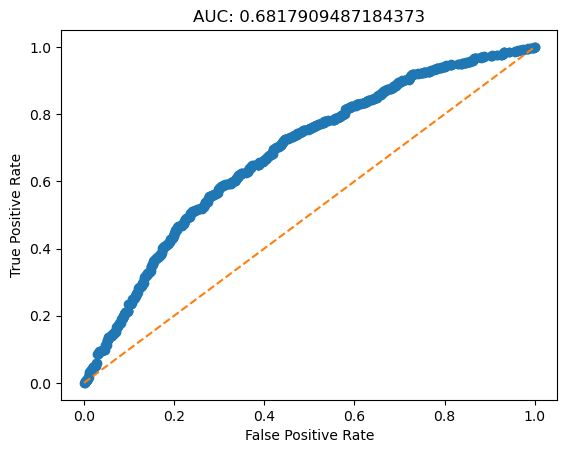

In [21]:
for target in logreg_targets:
    y = users[target]
    
    # In each loop X must be created anew:
    X = users.drop(target, axis='columns')

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42)

    model = LogisticRegression(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    psychogr_test[target] = round(cross_val_score(
        model, X, y, scoring='roc_auc', cv=10, n_jobs=-1).mean(), 2)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    plot_roc_curve(y_test, y_pred_proba)

In [22]:
psychogr_test

{'name': 'psychographic_data_only',
 'age': 0.14,
 'ope': 0.24,
 'con': 0.42,
 'ext': 0.49,
 'agr': 0.46,
 'neu': 0.63,
 'gender': 0.67}

Conclusion - without user-like data scikit-learn default estimators return slightly worse results in case of four of the Big Five features and significantly worse results in case of age, gender and Openness.

## SVD <i>k</i> = 300

Data preparation:

In [23]:
svd_300 = TruncatedSVD(n_components=300, random_state=42)

In [24]:
svd_300.fit(df)

TruncatedSVD(n_components=300, random_state=42)

In [25]:
X_svd_300 = svd_300.transform(df)

In [26]:
X_svd_300 = pd.DataFrame(X_svd_300)

In [27]:
merged_svd_300 = pd.concat([users, X_svd_300], axis=1)

Getting predictions:

In [28]:
merged_svd_300_results = {}
merged_svd_300_results['name'] = 'merged_svd_300_results'

In [29]:
for target in linreg_targets:
    y = users[target]
    
    # In each loop X must be created anew:
    loop_merged = pd.concat([users, merged_svd_300], axis=1)
    loop_merged.columns = loop_merged.columns.astype(str)
    loop_merged = loop_merged.drop(target, axis='columns')

    X_train, X_test, y_train, y_test = train_test_split(
        loop_merged, y, test_size=0.1, random_state=42)

    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)

    merged_svd_300_results[target] = round(cross_val_score(
        model, loop_merged, y, scoring=pearson_scorer, cv=10, n_jobs=-1).mean(), 2)

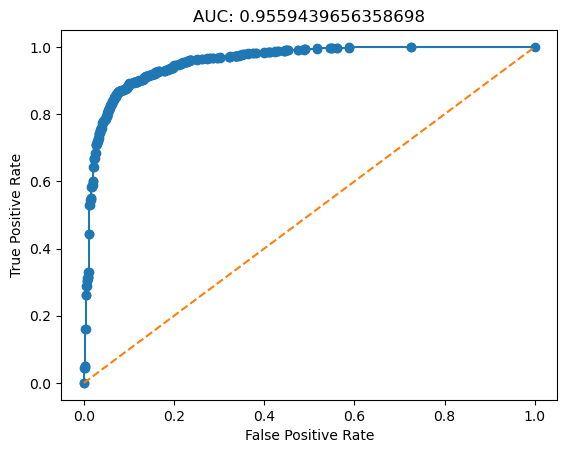

In [30]:
for target in logreg_targets:
    y = users[target]
    
    # In each loop X must be created anew:
    loop_merged = pd.concat([users, merged_svd_300], axis=1)
    loop_merged.columns = loop_merged.columns.astype(str)
    loop_merged = loop_merged.drop(target, axis='columns')

    X_train, X_test, y_train, y_test = train_test_split(
        loop_merged, y, test_size=0.1, random_state=42)

    model = LogisticRegression(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    merged_svd_300_results[target] = round(cross_val_score(
        model, loop_merged, y, scoring='roc_auc', cv=10, n_jobs=-1).mean(), 2)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    plot_roc_curve(y_test, y_pred_proba)

In [31]:
merged_svd_50_results

{'name': 'merged_svd_50_results',
 'age': 0.59,
 'ope': 0.51,
 'con': 0.45,
 'ext': 0.56,
 'agr': 0.5,
 'neu': 0.64,
 'gender': 0.94}

In [32]:
merged_svd_300_results

{'name': 'merged_svd_300_results',
 'age': 0.64,
 'ope': 0.53,
 'con': 0.45,
 'ext': 0.57,
 'agr': 0.51,
 'neu': 0.64,
 'gender': 0.96}

Improvement of 2% on gender (AUC), 5% on age (cor) when goin from 50 to 300 SVD dimensions.

## LDA <i>k</i> = 150

Data preparation:

In [33]:
lda_150 = LatentDirichletAllocation(n_components=150, random_state=42)

In [34]:
lda_150.fit(df)  # takes 6min:00s on my PC

LatentDirichletAllocation(n_components=150, random_state=42)

In [35]:
X_lda_150 = lda_150.transform(df)

In [36]:
X_lda_150 = pd.DataFrame(X_lda_150)

In [37]:
merged_lda_150 = pd.concat([users, X_lda_150], axis=1)

In [38]:
merged_lda_150

,gender,age,ope,con,ext,agr,neu,0,1,2,...,140,141,142,143,144,145,146,147,148,149
0,0,47,-0.31,-0.57,-0.89,0.41,1.17,0.000128,0.000128,0.000128,...,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128
1,0,35,0.61,-0.12,-0.64,-1.01,-1.50,0.000126,0.000126,0.000126,...,0.000126,0.000126,0.000126,0.000126,0.000126,0.000126,0.000126,0.000126,0.000126,0.000126
2,1,29,-0.31,-0.94,-0.77,-1.76,1.05,0.000078,0.000078,0.000078,...,0.000078,0.081683,0.000078,0.000078,0.000078,0.000078,0.084492,0.000078,0.000078,0.000078
3,1,28,-0.68,0.54,-0.52,-1.01,-0.51,0.000053,0.000053,0.000053,...,0.000053,0.155478,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053
4,0,35,-0.41,-0.86,-1.02,-0.18,0.30,0.000128,0.000128,0.000128,...,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19737,1,23,-0.31,-1.97,-1.21,-1.09,1.79,0.000068,0.000068,0.000068,...,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068
19738,1,26,1.26,0.17,1.11,0.12,0.18,0.000013,0.000013,0.000013,...,0.000013,0.000013,0.000013,0.080966,0.000013,0.000013,0.114835,0.000013,0.000013,0.000013
19739,1,20,-0.04,0.69,0.17,0.82,0.80,0.000119,0.000119,0.000119,...,0.000119,0.000119,0.000119,0.000119,0.000119,0.000119,0.000119,0.000119,0.000119,0.000119
19740,1,35,1.63,-0.72,1.86,1.41,-1.01,0.000079,0.000079,0.000079,...,0.137619,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079


Getting predictions:

In [39]:
merged_lda_150_results = {}
merged_lda_150_results['name'] = 'merged_lda_150_results'

In [40]:
for target in linreg_targets:
    y = users[target]
    
    # In each loop X must be created anew:
    loop_merged = pd.concat([users, merged_lda_150], axis=1)
    loop_merged.columns = loop_merged.columns.astype(str)
    loop_merged = loop_merged.drop(target, axis='columns')

    X_train, X_test, y_train, y_test = train_test_split(
        loop_merged, y, test_size=0.1, random_state=42)

    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)

    merged_lda_150_results[target] = round(cross_val_score(
        model, loop_merged, y, scoring=pearson_scorer, cv=10, n_jobs=-1).mean(), 2)

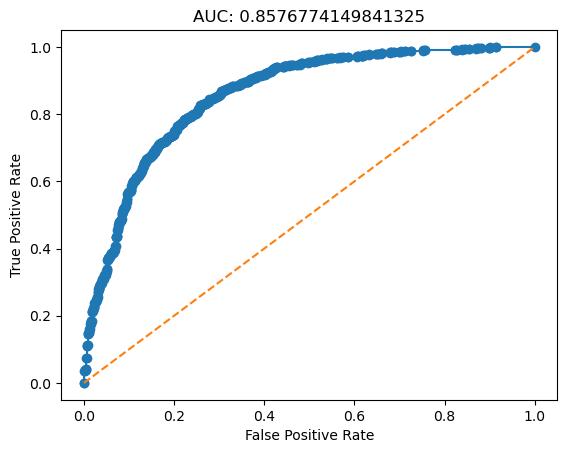

In [41]:
for target in logreg_targets:
    y = users[target]
    
    # In each loop X must be created anew:
    loop_merged = pd.concat([users, merged_lda_150], axis=1)
    loop_merged.columns = loop_merged.columns.astype(str)
    loop_merged = loop_merged.drop(target, axis='columns')

    X_train, X_test, y_train, y_test = train_test_split(
        loop_merged, y, test_size=0.1, random_state=42)

    model = LogisticRegression(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    merged_lda_150_results[target] = round(cross_val_score(
        model, loop_merged, y, scoring='roc_auc', cv=10, n_jobs=-1).mean(), 2)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    plot_roc_curve(y_test, y_pred_proba)

In [42]:
merged_lda_150_results

{'name': 'merged_lda_150_results',
 'age': 0.7,
 'ope': 0.46,
 'con': 0.44,
 'ext': 0.55,
 'agr': 0.47,
 'neu': 0.63,
 'gender': 0.87}

In [43]:
pd.DataFrame(merged_lda_150_results, index=[0])

,name,age,ope,con,ext,agr,neu,gender
0,merged_lda_150_results,0.7,0.46,0.44,0.55,0.47,0.63,0.87


### Merging all results for analysis:

In [44]:
merged_data_results = pd.DataFrame()

In [45]:
merged_data_results = merged_data_results.append(
    [psychogr_test,
     merged_svd_50_results,
     merged_svd_300_results,
     merged_lda_150_results],
    ignore_index=True
)

C:\Users\lubec\AppData\Local\Temp\ipykernel_33652\1244655093.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data_results = merged_data_results.append(


In [46]:
merged_data_results

,name,age,ope,con,ext,agr,neu,gender
0,psychographic_data_only,0.14,0.24,0.42,0.49,0.46,0.63,0.67
1,merged_svd_50_results,0.59,0.51,0.45,0.56,0.50,0.64,0.94
2,merged_svd_300_results,0.64,0.53,0.45,0.57,0.51,0.64,0.96
3,merged_lda_150_results,0.70,0.46,0.44,0.55,0.47,0.63,0.87


In [47]:
merged_data_results.to_csv('results/merged_data_results.csv')